In [1]:
!module load pytorch-gpu/py3/1.10.0
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c880338a-376a-95b5-1514-e8772da160db)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import modellib
import datalib
import training
import hrmes_tools
import conf
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
# dataset qui contient les donnees, ie la fonction de courant barotrope
MSFTdataset = hrmes_tools.load_msft()
MSFTdataset

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) float64 15.5 45.0 74.5 ... 1.826e+05 1.826e+05
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) float64 ...
    msftbarot       (time, y, x) float32 ...
Attributes: (12/51)
    name:                   /ccc/work/cont003/dsm/p86maf/IGCM_OUT/IPSLCM6/PRO...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-04-27T15:00:09Z
    tracking_id:            hdl:21.14100/17e4ba33-4948-4a89-b737-937464656d8d
    description:            DECK: control
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    variant_label:          r1i1p1f1
    EXPID:                  piControl
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          00e1a4f623b35a33620b9828c66bd1c8
    model_version:          6.1.2
    history:                Tue Jul 10 16:42:45 2018: ncatted -O -a coordinat...

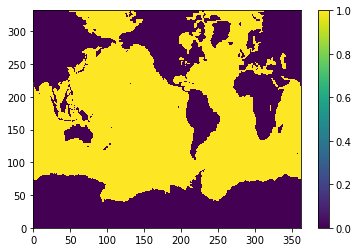

In [4]:
maskdataset = hrmes_tools.load_mask_ds()
mask = hrmes_tools.get_mask(maskdataset)
plt.pcolor(mask) ; plt.colorbar() ; plt.show()

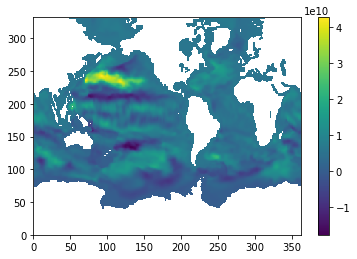

In [6]:
ssca = hrmes_tools.get_ssca(MSFTdataset.msftbarot)
plt.pcolor(ssca[458]) ; plt.colorbar() ; plt.show()

In [7]:
bool_mask, int_mask = hrmes_tools.make_mask(ssca)

In [8]:
maps = hrmes_tools.neighbor_normalization(ssca)

/gpfsdswork/projects/idris/sos/ssos025/HRMES/hrmes_tools.py:51: RuntimeWarning: Mean of empty slice
  np.nanmean(unfolded, axis=1, keepdims=True).reshape(1, 332, 362)
/linkhome/idris/genidr/ssos025/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
tmp = maps[:, bool_mask].numpy()

In [10]:
pca = hrmes_tools.pca(tmp, 2000)[0]

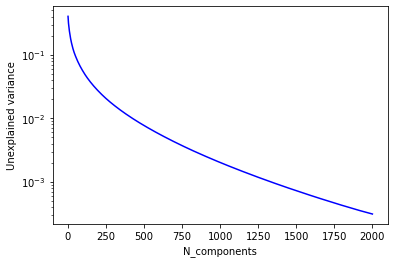

In [11]:
plt.plot(range(1, 2001), 1 - np.cumsum(pca.explained_variance_ratio_), "b-")
plt.yscale("log")
plt.ylabel("Unexplained variance")
plt.xlabel("N_components")
plt.show()

In [12]:
pca, maps = hrmes_tools.pca(tmp, 50)
maps = torch.from_numpy(maps)

In [13]:
maps = hrmes_tools.pointwise_normalization(maps)

In [14]:
maps.shape, maps.dtype

(torch.Size([6000, 50]), torch.float32)

In [15]:
data = hrmes_tools.make_data(maps)

In [16]:
train_ds, test_ds = datalib.make_datasets(maps, data)

There are 5000 training samples and 988 test_samples


In [17]:
train_dataloader, test_dataloader = datalib.make_dataloaders(train_ds, test_ds)

In [21]:
model, criterion, optimizer = modellib.define_model_optimizer_criterion(None, pca_model=True)

Model has 126850 parameters


Epoch  1


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  5


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  6


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  7


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  8


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  9


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  11


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  12


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  13


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  14


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  15


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  16


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  17


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  18


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  19


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  20


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  21


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  22


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  23


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  24


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  25


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  26


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  27


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  28


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  29


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  30


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  31


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  32


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  33


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  34


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  35


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  36


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  37


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  38


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  39


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  40


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  41


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  42


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  43


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  44


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  45


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  46


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  47


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  48


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  49


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  50


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  51


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  52


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  53


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  54


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  55


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  56


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  57


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  58


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  59


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  60


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  61


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  62


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  63


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  64


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  65


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  66


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  67


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  68


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  69


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  70


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  71


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  72


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  73


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  74


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  75


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  76


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  77


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  78


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  79


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  80


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  81


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  82


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  83


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  84


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  85


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  86


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  87


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  88


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  89


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  90


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  91


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  92


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  93


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  94


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  95


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  96


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  97


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  98


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  99


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch  100


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

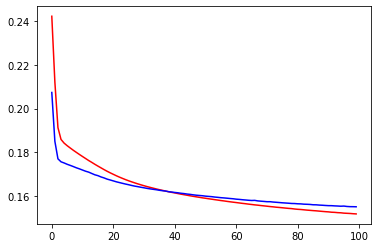

Final test loss: 0.1550736769192642


In [23]:
train_losses, test_losses = training.train(model, conf.epochs, train_dataloader, test_dataloader, optimizer, criterion, bool_mask=None)
plt.figure()
plt.plot(train_losses, "r-", label="Training loss")
if conf.epochs != 1:
    plt.plot(test_losses, "b-", label="Test loss")
plt.legend()
plt.show()
print(f"Final test loss: {test_losses[-1]}")

Chosen idx: 120
Mean of ground truth: 0.009 ; Std of ground truth: 0.011
Mean of predicted map: -0.000 ; Std of predicted map: 0.004


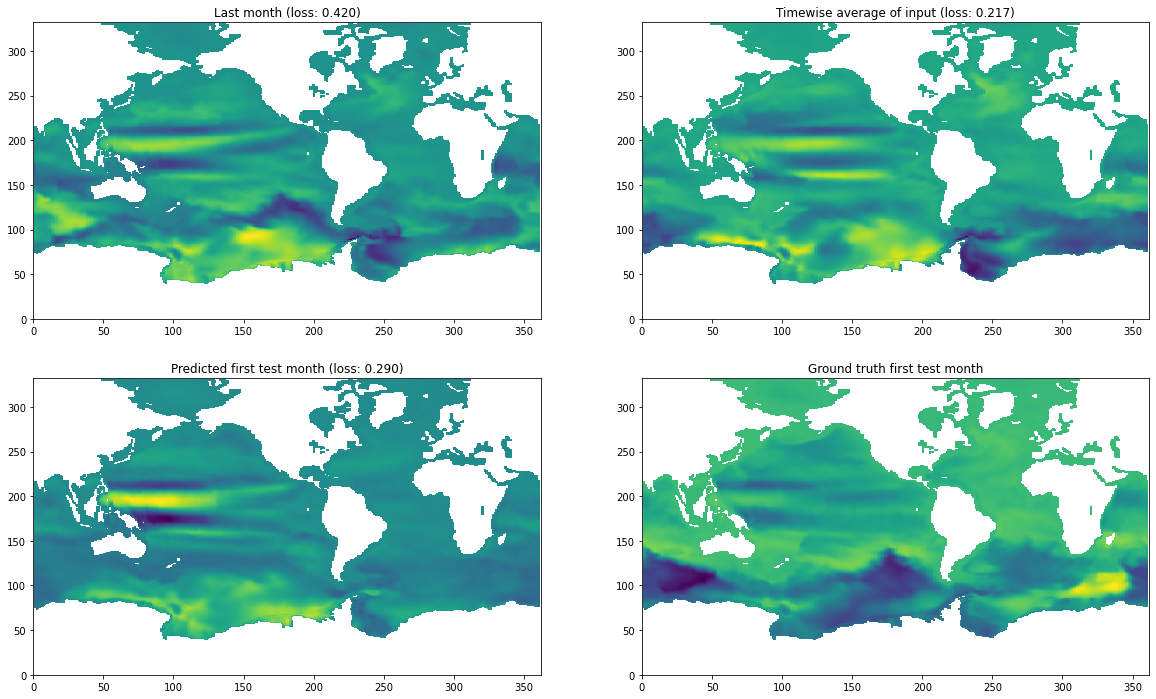

In [25]:
training.test_sample_pca(model, criterion, test_ds, bool_mask, pca)
plt.show()

  0%|          | 0/98 [00:00<?, ?it/s]

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


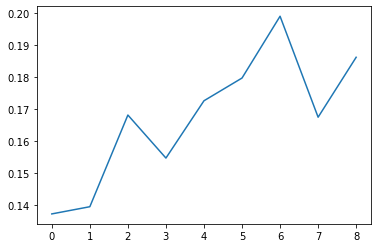

In [26]:
losses = training.quantify_quality_average(model, criterion, test_ds, bool_mask)
plt.plot(losses) ; plt.show()